<a href="https://colab.research.google.com/github/Umesh27/BLE_learn/blob/master/weather_classifier_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from collections import namedtuple
import copy, math, os, sys, torch
import matplotlib.pyplot as plt
import numpy as np
from operator import add
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score
from torch import Tensor, nn, optim
import torch.nn.functional as F
import torchvision.utils
from torchvision.models import vgg
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm

In [34]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [35]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [36]:
# data_path = r"C:\Umesh\Umesh_Backup\Interview_Practical\Exercise_Rysun\Computer_vision\weather_data"
data_path = '/content/drive/My Drive/OpenCV_Exercise/weather_data'
categories = os.listdir(data_path)
print(categories)
category_files = {cat: os.listdir(f'{data_path}/{cat}') for cat in categories}


['shine', 'cloudy', 'sunrise', 'rain']


In [37]:
# Connect to GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [38]:
import random

In [39]:
[f'{data_path}/{cat}/{random.choice(category_files[cat])}' for cat in categories]

['/content/drive/My Drive/OpenCV_Exercise/weather_data/shine/shine209.jpg',
 '/content/drive/My Drive/OpenCV_Exercise/weather_data/cloudy/cloudy253.jpg',
 '/content/drive/My Drive/OpenCV_Exercise/weather_data/sunrise/sunrise71.jpg',
 '/content/drive/My Drive/OpenCV_Exercise/weather_data/rain/rain108.jpg']

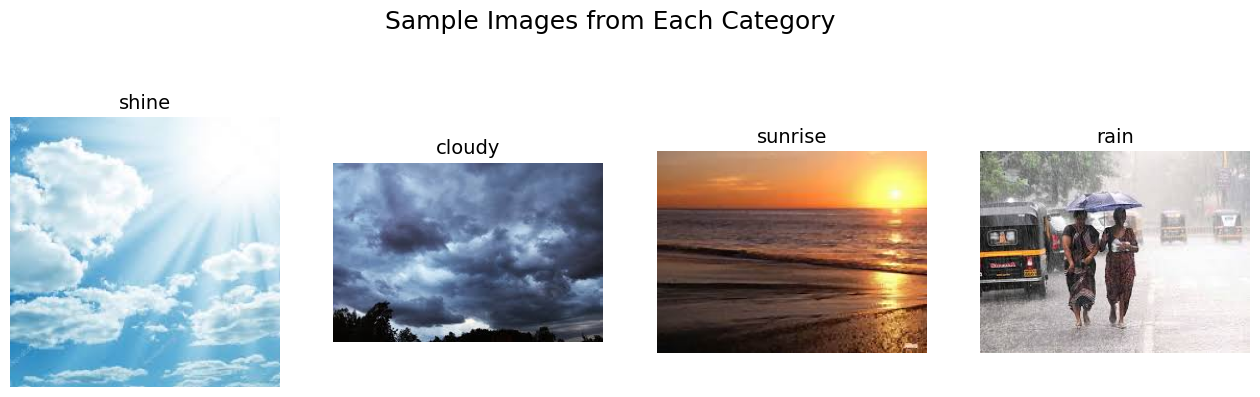

In [ ]:
sample_images = [Image.open(f'{data_path}/{cat}/{random.choice(category_files[cat])}') for cat in categories]
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
for i, ax in enumerate(axs):
    ax.imshow(sample_images[i])
    ax.set_title(categories[i], fontsize=14)
    ax.axis('off')
plt.suptitle("Sample Images from Each Category", fontsize=18)
plt.show()

# Data Transformations

In [ ]:
# Data transformations (increased variety)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_path, transform=data_transforms)
# Splitting dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])
print(len(train_data), len(val_data), len(test_data))

801 171 173


In [ ]:
train_size, val_size, test_size

(801, 171, 173)

801 1602 171 173


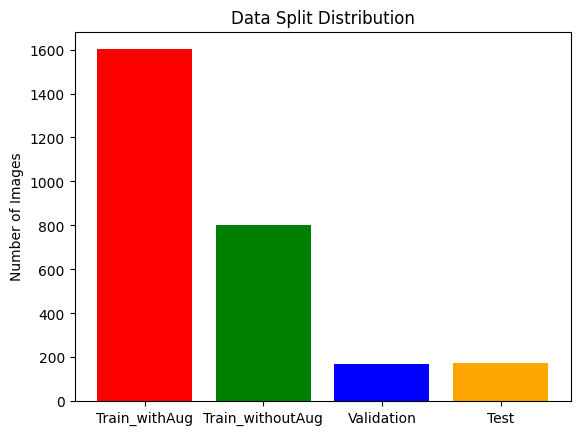

In [ ]:
# Data augmentation for training set
augmentation_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets with augmentation
augmented_train_data = copy.deepcopy(train_data)
augmented_train_data.dataset.transform = augmentation_transforms
final_train_data = ConcatDataset([train_data, augmented_train_data])
print(len(train_data), len(final_train_data), len(val_data), len(test_data))

# Visualization: dataset distribution
dataset_counts = [len(final_train_data), len(train_data), len(val_data), len(test_data)]
plt.bar(['Train_withAug', 'Train_withoutAug', 'Validation', 'Test'], dataset_counts, color=['red', 'green', 'blue', 'orange'])
plt.title('Data Split Distribution')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
# DataLoader Wrapper to Apply Preprocessing
class DataLoaderWrapper:
    def __init__(self, data_loader, transform_func):
        # data_loader: Original DataLoader providing batches of data
        # transform_func: Function to apply transformations to each batch
        self.data_loader = data_loader
        self.transform_func = transform_func

    def __len__(self):
        # Return the number of batches in the original DataLoader
        return len(self.data_loader)

    def __iter__(self):
        # Create an iterator from the original DataLoader
        batch_iterator = iter(self.data_loader)
        # Apply the transformation function to each batch and yield the result
        for batch in batch_iterator:
            yield (self.transform_func(*batch))

# Function to transfer data to the specified device (e.g., GPU)
def transfer_to_device(inputs, targets):
    # Move input and target tensors to the specified device (e.g., GPU)
    return inputs.to(dev), targets.to(dev)

In [ ]:
# Create dataloaders
BATCH_SIZE = 32
train_dl = torch.utils.data.DataLoader(final_train_data, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=len(val_data))
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
train_dl = DataLoaderWrapper(train_dl, transfer_to_device)
val_dl = DataLoaderWrapper(val_dl, transfer_to_device)
test_dl = DataLoaderWrapper(test_dl, transfer_to_device)

<ipython-input-15-ecee9dd3b591>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize='15')


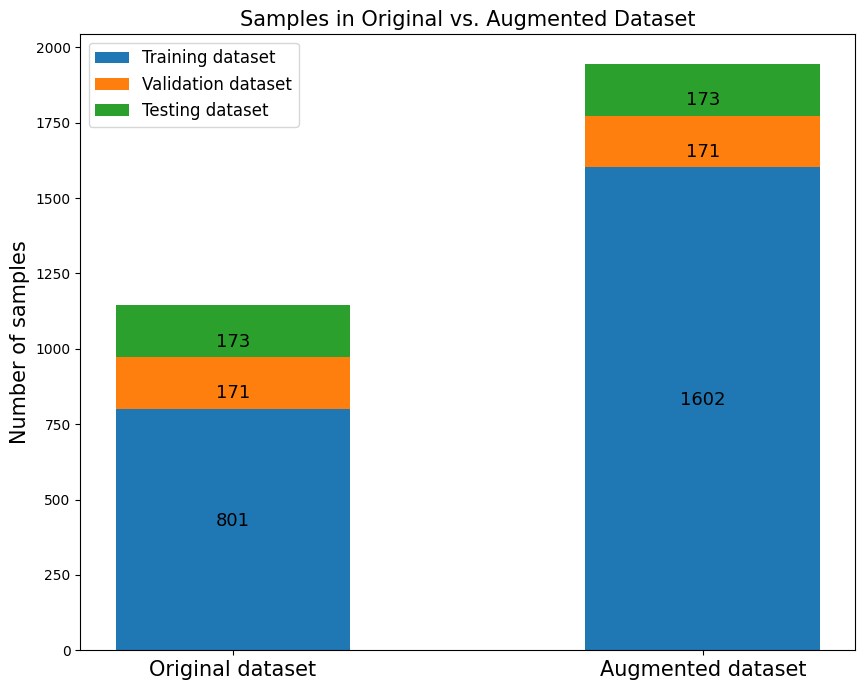

In [ ]:
# Plot size of datasets in bar chart
labels = ['Original dataset', 'Augmented dataset']
train_nos = [train_size, len(final_train_data)]
val_nos = [val_size, len(val_data)]
test_nos = [test_size, len(test_data)]
width = 0.5
fig, ax = plt.subplots(figsize=(10,8))
trn_bars = ax.bar(labels, train_nos, width, label='Training dataset')
val_bars = ax.bar(labels, val_nos, width, bottom=train_nos, label='Validation dataset')
tst_bars = ax.bar(labels, test_nos, width, bottom=list(map(add, train_nos, val_nos)), label='Testing dataset')
for i in range(len(trn_bars)):
    ax.annotate(str(train_nos[i]), xy=(labels[i],train_nos[i]/2), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(val_nos[i]), xy=(labels[i],val_nos[i]/2+train_nos[i]-63), ha='center', va='bottom', fontsize='13')
    ax.annotate(str(test_nos[i]), xy=(labels[i],test_nos[i]/2+list(map(add, train_nos, val_nos))[i]-65), ha='center', va='bottom', fontsize='13')
ax.set_ylabel('Number of samples', fontsize='15')
ax.set_title('Samples in Original vs. Augmented Dataset', fontsize='15')
ax.set_xticklabels(labels, fontsize='15')
ax.legend(fontsize='12')
plt.show()

In [ ]:
train_nos, val_nos, test_nos

([801, 1602], [171, 171], [173, 173])

### Train Functions

In [ ]:
# Calculate loss for each batch and backpropagate this through the network
def compute_loss(model, feature_extractor, criterion, images, labels, opt=None):

    # Use pretarined cnn to extract features
    extracted_features = feature_extractor(images)[4]

    # Train classifier on features of pretrained network convolutional layer
    predictions = model(extracted_features)
    loss = criterion(predictions, labels)

    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Calculate batch accuracy
    confidence, predicted = torch.max(predictions.data, 1)
    correct = (predicted == labels).sum().item()

    return loss.item(), correct, labels.size(0)

In [ ]:
# Train model
def train(epochs, model, feature_extractor, loss_func, opt, train_loader, val_loader, batches):

    # Lists to track training progress
    train_losses = []
    validation_losses = []
    train_accs = []
    validation_accs = []
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print('Training progress:')
    for epoch in tqdm(range(epochs)):   # Show progress bar with tqdm

        # print('Epoch {}/{}'.format(epoch+1, epochs))
        batch = 1
        model.train()
        running_loss, correct, total = 0, 0, 0

        # Iterate through batches, train model
        for images, labels in train_loader:
            batch_loss, batch_correct, batch_size = compute_loss(model, feature_extractor, loss_func, images, labels, opt)
            running_loss += batch_loss
            correct += batch_correct
            total += batch_size
            batch+=1

        # Use validation data to check for overfitting
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[compute_loss(model, feature_extractor, loss_func, images, labels) for images, labels in val_loader])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(corrects) / np.sum(nums)

        train_loss = running_loss / len(train_loader)
        train_acc = correct/total
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


        # print('loss = {}      accuracy = {}      val_loss = {}      val_accuracy: {}'.format(loss, train_acc, val_loss, val_acc))

    print('Final training loss =   {}      final training accuracy =   {}'.format(train_loss, train_acc))
    print('Final validation loss = {}      final validation accuracy = {}'.format(val_loss, val_acc))

    # Save state dict for future loading of trained model
    torch.save(model.state_dict(), '/content/drive/My Drive/WeatherClassificationModels/classifier_{}'.format(epoch+1))
    torch.save(opt.state_dict(), '/content/drive/My Drive/WeatherClassificationModels/classifier_opt_{}'.format(epoch+1))
    print('Saved state dict')

    return history, model

In [ ]:
# Network module for pretrained model
class ConvNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(ConvNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3",
            '30': "mpool"
        }
        self.ConvOutput = namedtuple("ConvOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3", "mpool"])

    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return self.ConvOutput(**output)

In [ ]:
# Load pretrained model
vgg_model = vgg.vgg16(pretrained=True)
vgg_model.to(dev)
conv_network = ConvNetwork(vgg_model)
conv_network.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]


ConvNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
# Classifier neural network to predict weather conditions
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512*7*7, 64)
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.dense3 = nn.Linear(64, 4)
        self.softm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.bn1(self.relu3(self.dense1(x)))
        x = self.dense3(x)
        x = self.softm(x)
        return x

In [ ]:
# Classifier network
model = Classifier()
# Store model on GPU for training
model.to(dev)

# Hyperparameters
loss_func = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-6
EPOCHS = 200
BATCH_SIZE = BATCH_SIZE
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
batches = math.ceil(len(train_dl)/BATCH_SIZE)

# Train network
history, model_final = train(EPOCHS, model, conv_network, loss_func, opt, train_dl, val_dl, batches)


Training progress:


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Train Loss: 1.3796, Val Loss: 1.3428, Train Acc: 0.2890, Val Acc: 0.3918
Epoch 2/200, Train Loss: 1.3432, Val Loss: 1.3327, Train Acc: 0.3801, Val Acc: 0.4152
Epoch 3/200, Train Loss: 1.3086, Val Loss: 1.2619, Train Acc: 0.4719, Val Acc: 0.5848
Epoch 4/200, Train Loss: 1.2823, Val Loss: 1.2185, Train Acc: 0.5581, Val Acc: 0.6959
Epoch 5/200, Train Loss: 1.2571, Val Loss: 1.2065, Train Acc: 0.6049, Val Acc: 0.6901
Epoch 6/200, Train Loss: 1.2345, Val Loss: 1.1490, Train Acc: 0.6386, Val Acc: 0.8129
Epoch 7/200, Train Loss: 1.2082, Val Loss: 1.1378, Train Acc: 0.6723, Val Acc: 0.7778
Epoch 8/200, Train Loss: 1.1849, Val Loss: 1.1298, Train Acc: 0.6985, Val Acc: 0.7836
Epoch 9/200, Train Loss: 1.1678, Val Loss: 1.0967, Train Acc: 0.7335, Val Acc: 0.8246
Epoch 10/200, Train Loss: 1.1558, Val Loss: 1.0713, Train Acc: 0.7235, Val Acc: 0.8363
Epoch 11/200, Train Loss: 1.1350, Val Loss: 1.0749, Train Acc: 0.7672, Val Acc: 0.8713
Epoch 12/200, Train Loss: 1.1191, Val Loss: 1.0474, 

ValueError: not enough values to unpack (expected 4, got 2)

In [55]:

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle('Training Curves', fontsize=20)

ax1.plot(train_losses)
ax1.plot(val_losses)
ax1.set_title('Loss', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_yscale('log')
ax1.legend(['train', 'validation'], loc = 'upper right', fontsize=12)

ax2.plot(np.multiply(train_accs,100))
ax2.plot(np.multiply(val_accs,100))
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=14)
# plt.yscale('log')
ax2.legend(['train', 'validation'], loc = 'lower right', fontsize=12)

plt.show()

In [41]:
# Load saved network weights
model = Classifier()
model.to(dev)
model.load_state_dict(torch.load('/content/drive/My Drive/WeatherClassificationModels/classifier_200'))
model.eval()

<ipython-input-41-8d1ff05cea0c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/WeatherClassificationModels/classi

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=25088, out_features=64, bias=True)
  (relu3): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=64, out_features=4, bias=True)
  (softm): Softmax(dim=1)
)

In [42]:
# Test model on testing dataset
weather_conditions = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
correct_pred = {classname: 0 for classname in weather_conditions}
total_pred = {classname: 0 for classname in weather_conditions}
correct = 0
total = 0
confusion_matrix = np.zeros((len(weather_conditions), len(weather_conditions)))

with torch.no_grad():
    for images, labels in test_dl:
        predictions = model(conv_network(images)[4])
        confidence, predicted = torch.max(predictions.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Analyse errors for per-class accuracy and confusion matrix
        for true_label, pred_label in zip(labels, predicted):
            if true_label == pred_label:
                correct_pred[weather_conditions[true_label]] += 1
            total_pred[weather_conditions[true_label]] += 1
            confusion_matrix[true_label, pred_label] += 1

# Calculate per-class accuracy
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

print('----------------------------------------')
print('Network Accuracy: {:.2f} %'.format(100 * correct / total))
print('----------------------------------------')
print(classification_report(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy()))


Accuracy for class Cloudy is: 95.8 %
Accuracy for class Rain  is: 100.0 %
Accuracy for class Shine is: 95.6 %
Accuracy for class Sunrise is: 94.1 %
----------------------------------------
Network Accuracy: 95.95 %
----------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       0.97      1.00      0.98        29
           2       0.96      0.96      0.96        45
           3       1.00      0.94      0.97        51

    accuracy                           0.96       173
   macro avg       0.96      0.96      0.96       173
weighted avg       0.96      0.96      0.96       173



<ipython-input-43-ab2d9176da49>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_labels, fontsize='15')


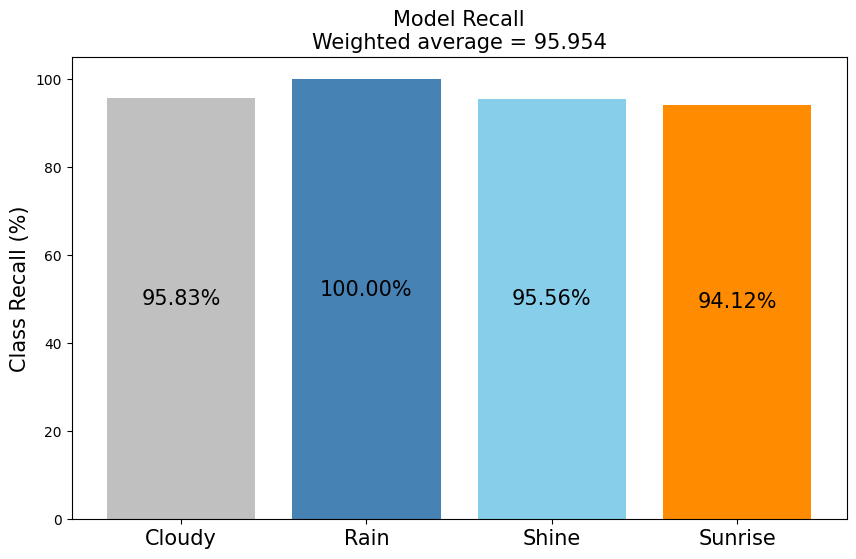

<ipython-input-43-ab2d9176da49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_labels, fontsize='15')


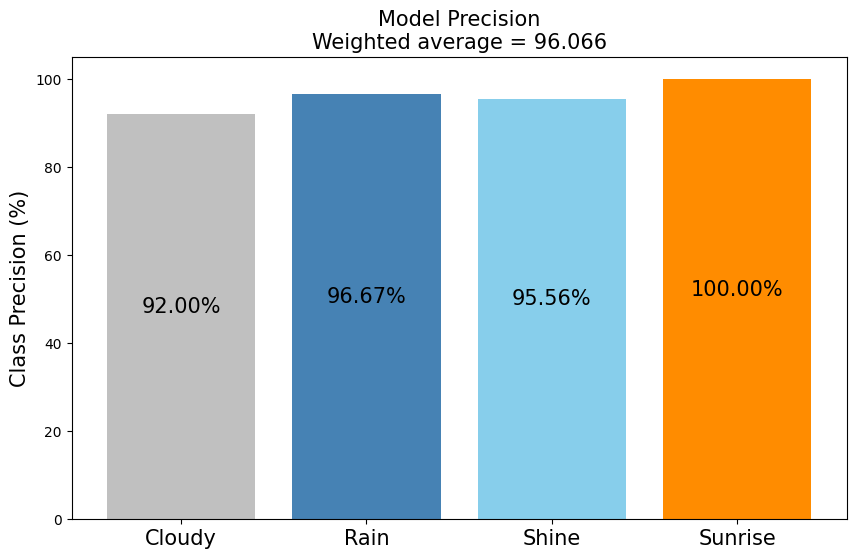

In [43]:
# Plot recall as bar chart
bar_labels = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
recalls = np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, recalls, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(recalls[i]), xy=(bar_labels[i],recalls[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Recall (%)', fontsize='15')
ax.set_title('Model Recall\nWeighted average = {:.3f}'.format(np.multiply(recall_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

# Plot precision as bar chart
precs = np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average=None), 100)
width = 0.8
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(bar_labels, precs, width, color=['silver', 'steelblue', 'skyblue', 'darkorange'])
for i in range(len(bars)):
    ax.annotate('{:.2f}%'.format(precs[i]), xy=(bar_labels[i],precs[i]/2), ha='center', va='bottom', fontsize='15')
ax.set_ylabel('Class Precision (%)', fontsize='15')
ax.set_title('Model Precision\nWeighted average = {:.3f}'.format(np.multiply(precision_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy(), average='weighted'), 100)), fontsize='15')
ax.set_xticklabels(bar_labels, fontsize='15')
plt.show()

